# Completing Historical Temperature records with LSTM in Python

https://medium.com/analytics-vidhya/completing-historical-temperature-records-with-lstm-in-python-f505b10289e7

https://github.com/gnaya73/medium

# Handling Outliers 

In [1]:
import pandas as pd
import numpy as np
import os
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

random.seed(7)

In [2]:
df = pd.read_csv("CoCoRaHs_Reg4.csv", parse_dates=["DATE"])
df.set_index('DATE',inplace=True)
print(df.describe())

            LATITUDE      LONGITUDE      ELEVATION           PRCP  \
count  691683.000000  691683.000000  691683.000000  249033.000000   
mean       40.614650    -123.149282     665.203173       0.179896   
std         0.957032       0.594506     538.058815       0.470019   
min        38.508471    -124.281608       0.000000       0.000000   
25%        39.927800    -123.603600     152.400000       0.000000   
50%        40.710884    -123.083300     579.100000       0.000000   
75%        41.307500    -122.696700    1088.100000       0.100000   
max        42.080000    -122.144700    1844.000000      12.410000   

                TMAX           TMIN  
count  461946.000000  461938.000000  
mean       67.022782      43.772602  
std        22.415863      14.107114  
min      -100.000000    -100.000000  
25%        52.000000      35.000000  
50%        66.000000      43.000000  
75%        82.000000      52.000000  
max      4177.000000    4177.000000  


# Drop Temperature > 120 oF or <0

In [3]:
df.loc[df.TMIN > 90, 'TMIN'] = np.nan
df.loc[df.TMIN < 0, 'TMIN'] = np.nan

df.loc[df.TMAX > 121, 'TMAX'] = np.nan
df.loc[df.TMAX < 30 , 'TMAX'] = np.nan

# Pivot Table

In [4]:
df.pivot_table(df,'STATION',aggfunc=np.max)

,ELEVATION,LATITUDE,LONGITUDE,NAME,PRCP,TMAX,TMIN
STATION,,,,,,,
US1CACL0001,27.7,39.349023,-122.177112,MAXWELL 5.1 N,3.82,NaN,NaN
US1CADN0001,19.8,41.824032,-124.148236,CRESCENT CITY 5.5 NNE,6.68,NaN,NaN
US1CADN0005,29.9,41.799773,-124.142767,CRESCENT CITY 4.2 NE,6.15,NaN,NaN
US1CADN0006,36.6,41.915283,-124.135986,SMITH RIVER 1.1 SSE,7.07,NaN,NaN
US1CADN0007,14.9,41.865256,-124.151284,FORT DICK 0.2 SSW,6.36,NaN,NaN
...,...,...,...,...,...,...,...
USR0000CYOL,1378.8,40.337500,-123.065600,YOLLA BOLLA,NaN,106.0,73.0
USR0000CYUR,150.9,41.289700,-123.857500,YUROK,NaN,117.0,79.0
USR0000OSQU,1513.0,42.066700,-123.016700,SQUAW PEAK,NaN,120.0,89.0


Text(0, 0.5, 'TMAX (F)')

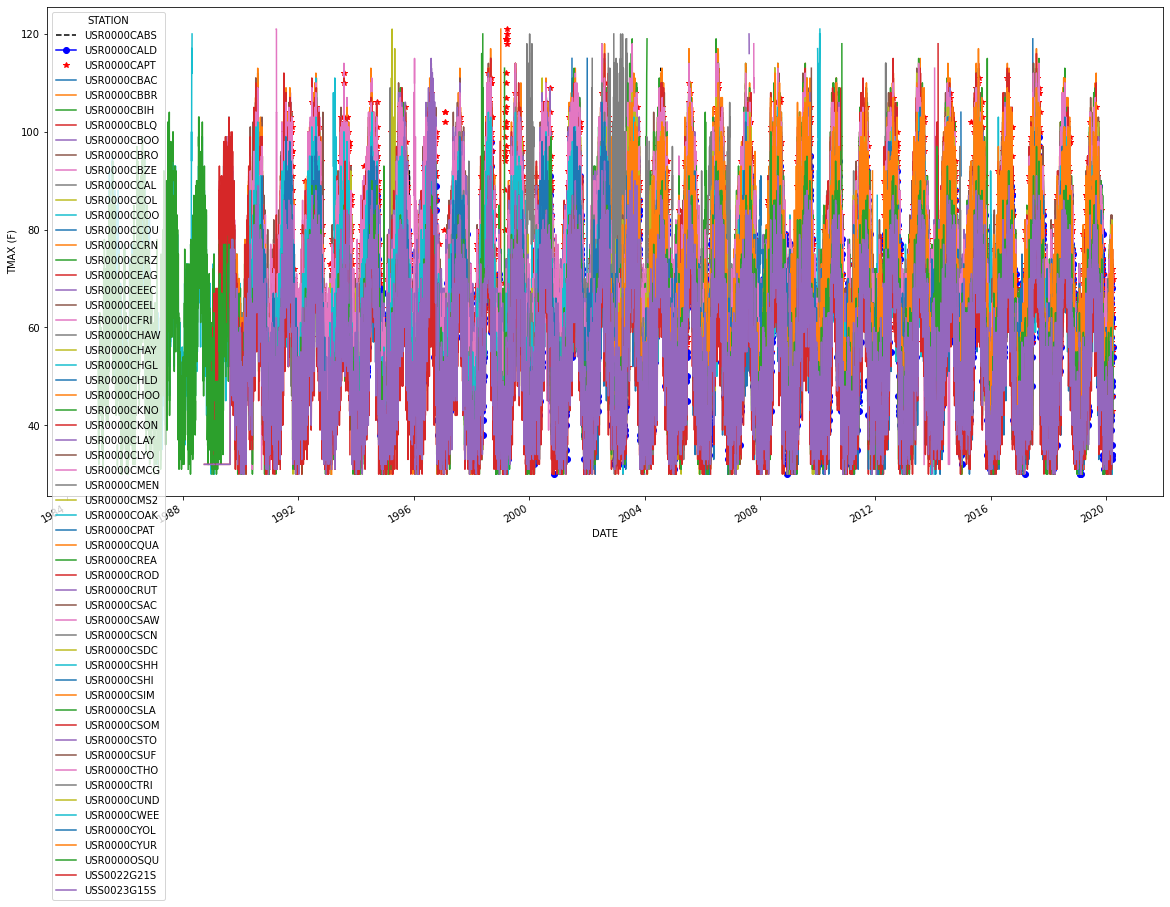

In [5]:
# P1 = pd.pivot_table(df, values='TMIN',index=['DATE'], columns=['STATION'])
# P1 = pd.pivot_table(df, values='PRCP',index=['DATE'], columns=['STATION'])
import matplotlib.pyplot as plt 
P1 = pd.pivot_table(df, values='TMAX',index=['DATE'], columns=['STATION'])
P1.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))
plt.ylabel("TMAX (F)")

In [6]:
# Select a few Stations and plot climate data
P2 = P1[['USR0000CCOO','USR0000CLAY','USR0000CCRZ','USS0022G21S','USR0000CEEC','USS0023G15S']]
print(P2)

STATION     USR0000CCOO  USR0000CLAY  USR0000CCRZ  USS0022G21S  USR0000CEEC  \
DATE                                                                          
1985-01-23          NaN          NaN         53.0          NaN          NaN   
1985-01-24          NaN          NaN         48.0          NaN          NaN   
1985-01-25          NaN          NaN         47.0          NaN          NaN   
1985-01-26          NaN          NaN         43.0          NaN          NaN   
1985-01-28          NaN          NaN         40.0          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2020-03-18         45.0         55.0         52.0         33.0         59.0   
2020-03-19         54.0         60.0         56.0         37.0         61.0   
2020-03-20         54.0         59.0         56.0         42.0         65.0   
2020-03-21         63.0         70.0         60.0          NaN         73.0   
2020-03-22         58.0         59.0         56.0   

Text(0, 0.5, 'TMAX (F)')

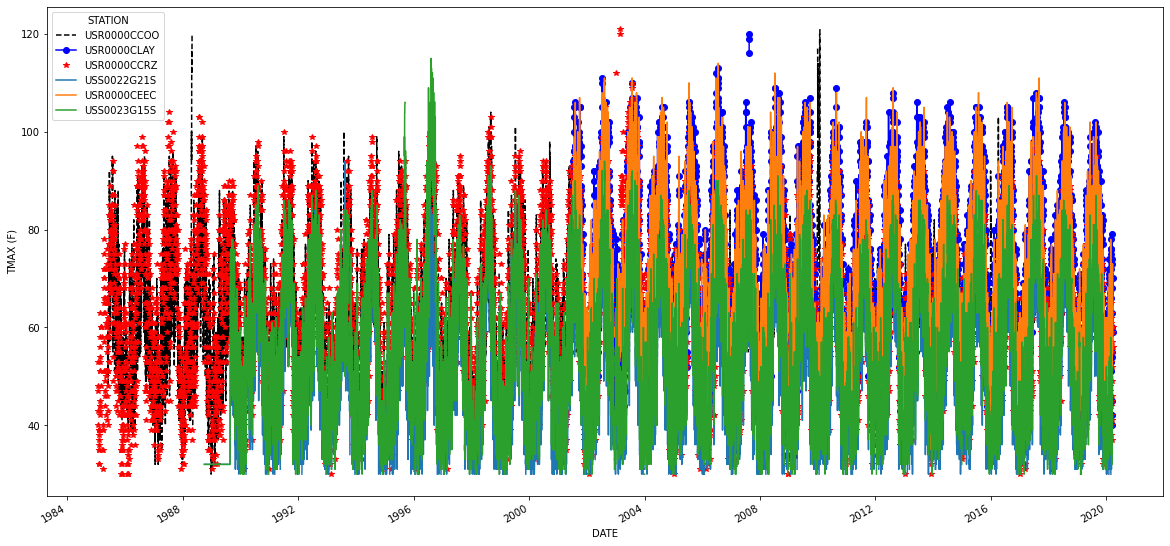

In [7]:
P2.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))
plt.ylabel("TMAX (F)")

# Fill out Missing data by Using LSTM

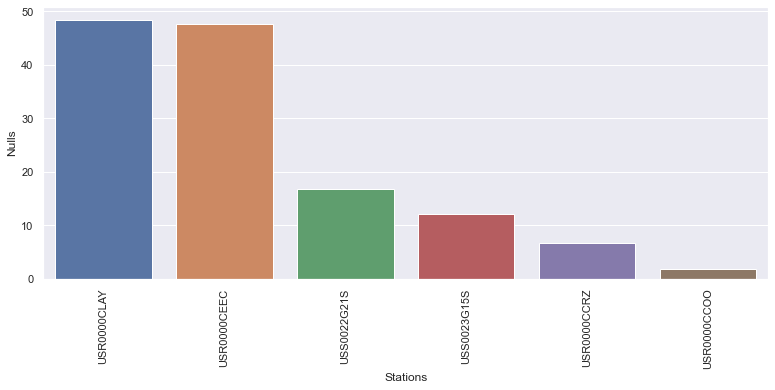

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

Isnull = P2.isnull().sum()/len(P2)*100
Isnull = Isnull[Isnull>0]
Isnull.sort_values(inplace=True, ascending=False)
Isnull = Isnull.to_frame()
Isnull.columns = ['Nulls']
Isnull.index.names = ['Stations']
Isnull['Stations'] = Isnull.index
# plot Missing values
plt.figure(figsize=(13, 5))
sns.set(style='darkgrid',color_codes=True,)
sns.barplot(x='Stations', y='Nulls', data=Isnull)
plt.xticks(rotation = 90)
plt.show()

# Visualizing null data in heatmap

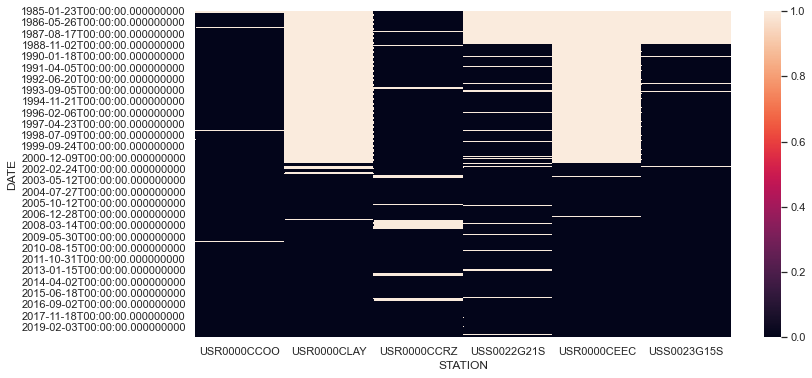

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(P2.isnull())
plt.show()

We can observe that the information (black background) is quite compact in the period 
January-1985 to December 2000
Dropping null records in the whole dataset we we have a final set of 1477 records,
between 01/23/1985 and 12/31/1990

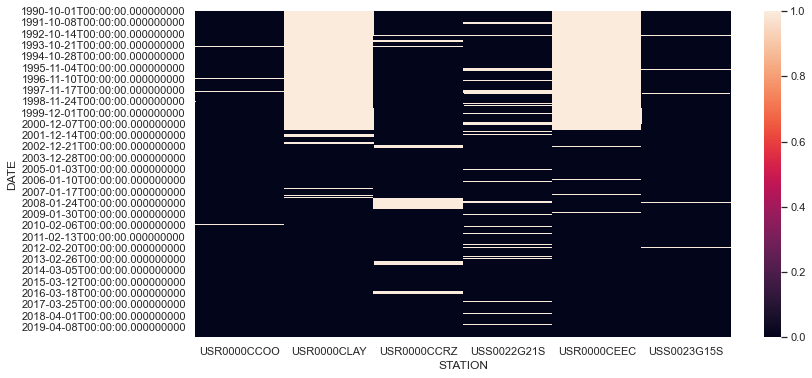

In [10]:
plt.figure(figsize=(12, 6))
sns.heatmap(P2.loc['1990-10-01':'2020-12-31'].isnull())
plt.show()

In [11]:
 P2.dropna(inplace=True)
 P2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5448 entries, 2001-07-11 to 2020-03-20
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   USR0000CCOO  5448 non-null   float64
 1   USR0000CLAY  5448 non-null   float64
 2   USR0000CCRZ  5448 non-null   float64
 3   USS0022G21S  5448 non-null   float64
 4   USR0000CEEC  5448 non-null   float64
 5   USS0023G15S  5448 non-null   float64
dtypes: float64(6)
memory usage: 297.9 KB


C:\Users\elham\.conda\envs\r-tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


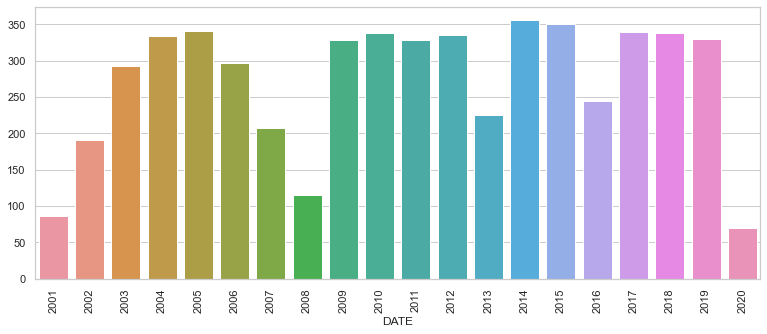

In [12]:
anual = P2.groupby(P2.index.year)
serie = anual.size()

plt.figure(figsize=(13, 5))
sns.set(style='whitegrid')
sns.barplot(x=serie.index, y=serie)
plt.xticks(rotation = 90)
plt.show()

# Let's start working with regression algorithms, we are going to make a copy of the
# "merge" dataset to leave the original intact

In [13]:
# print aca freno

In [14]:
data = P2.copy()
data.head(20)

STATION,USR0000CCOO,USR0000CLAY,USR0000CCRZ,USS0022G21S,USR0000CEEC,USS0023G15S
DATE,,,,,,
2001-07-11,76.0,78.0,74.0,66.0,78.0,68.0
2001-07-12,78.0,89.0,80.0,67.0,90.0,71.0
2001-07-13,68.0,94.0,85.0,69.0,85.0,72.0
2001-07-14,66.0,92.0,83.0,65.0,82.0,72.0
2001-07-15,58.0,93.0,77.0,63.0,77.0,65.0
2001-07-16,57.0,83.0,74.0,57.0,79.0,62.0
2001-07-17,61.0,86.0,72.0,59.0,81.0,61.0
2001-07-18,67.0,90.0,77.0,61.0,85.0,67.0
2001-07-19,59.0,84.0,79.0,65.0,80.0,67.0


In [15]:
# We add sine and cosine depending on the day of the year, in case we need that information later
# We create a column for the day of the year, which will go from 0 to 360

data['Day'] = 0
length_months = [31,28,31,30,31,30,31,31,30,31,30,31]

for idx,row in data.iterrows():
    day = idx.day
    if idx.month > 1:
        for m in range(idx.month-1):
            day = day + length_months[m]
    if day >= 360:
        day = 0    
    data.loc[data.index == idx ,'Day'] = float(day)

  
data['Sin'] = np.abs(np.sin(data['Day'] * np.pi/180)) 
data['Cos'] = np.abs(np.cos(data['Day'] * np.pi/180))
data.head(10)

STATION,USR0000CCOO,USR0000CLAY,USR0000CCRZ,USS0022G21S,USR0000CEEC,USS0023G15S,Day,Sin,Cos
DATE,,,,,,,,,
2001-07-11,76.0,78.0,74.0,66.0,78.0,68.0,192.0,0.207912,0.978148
2001-07-12,78.0,89.0,80.0,67.0,90.0,71.0,193.0,0.224951,0.974370
2001-07-13,68.0,94.0,85.0,69.0,85.0,72.0,194.0,0.241922,0.970296
2001-07-14,66.0,92.0,83.0,65.0,82.0,72.0,195.0,0.258819,0.965926
2001-07-15,58.0,93.0,77.0,63.0,77.0,65.0,196.0,0.275637,0.961262
2001-07-16,57.0,83.0,74.0,57.0,79.0,62.0,197.0,0.292372,0.956305
2001-07-17,61.0,86.0,72.0,59.0,81.0,61.0,198.0,0.309017,0.951057
2001-07-18,67.0,90.0,77.0,61.0,85.0,67.0,199.0,0.325568,0.945519
2001-07-19,59.0,84.0,79.0,65.0,80.0,67.0,200.0,0.342020,0.939693


# Using the LSTM network to predict missing data records

First, let’s scale the data using MinMaxScaler. I like using a dataset copy in my 
Jupiter Notebook at the end of feature work, then I can make differents approaches to the goal without affecting the final dataset.
In this case, variables have similar values, then scaling could not be neccesary,
but I like to work with low and similar values always it is posible.

In [16]:
#print (math.sin(math.radians(45)))
#print (math.sin(45 * (np.pi/180) ))

In [17]:
# Let's go for an approximation
cols = ['USR0000CCOO','USR0000CLAY','USR0000CCRZ','USS0022G21S','USR0000CEEC','USS0023G15S'] 

X = data[cols]
X.reset_index(inplace=True, drop=True)

Y = data['USR0000CLAY']
Y.reset_index(inplace=True, drop=True)

#  When cutting the dataset we respect the sequentiality of the data
rate = 0.75  
tst_train = int(len(data)*rate)
tst_test = len(data) - tst_train

X_train, X_test = X.iloc[0:tst_train,:],X.iloc[tst_train:len(X),:]
y_train, y_test = Y.iloc[0:tst_train],Y.iloc[tst_train:len(Y)]

print ("Shape of X_train & y_train : ",X_train.shape,y_train.shape)
print ("Shape of X_test  & y_test  : ", X_test.shape , y_test.shape)

Shape of X_train & y_train :  (4086, 6) (4086,)
Shape of X_test  & y_test  :  (1362, 6) (1362,)


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, accuracy_score, confusion_matrix

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10,
                                loss='huber', random_state=7)
gbr_model_full_data = gbr.fit(X_train, y_train)
print('Gradiente RMSLE score on train data:')
print(rmsle(y_train, gbr_model_full_data.predict(X_train)))
print("Accuracy --> ", gbr_model_full_data.score(X_train, y_train)*100)

print('Gradiente RMSLE score on test data:')
print(rmsle(y_test, gbr_model_full_data.predict(X_test)))
print("Accuracy --> ", gbr_model_full_data.score(X_test, y_test)*100)

Gradiente RMSLE score on train data:
0.35998053996252627
Accuracy -->  99.95034732307244
Gradiente RMSLE score on test data:
0.3256606765117753
Accuracy -->  99.96223066338486


# Let's go for an LSTM network

In [19]:
from sklearn.preprocessing import MinMaxScaler
dataset = P2.copy()
scaler = MinMaxScaler()
reshape  = ['USR0000CCOO','USR0000CLAY','USR0000CCRZ','USS0022G21S','USR0000CEEC','USS0023G15S']
dataset[reshape] = scaler.fit_transform(dataset[reshape])
dataset.head()

STATION,USR0000CCOO,USR0000CLAY,USR0000CCRZ,USS0022G21S,USR0000CEEC,USS0023G15S
DATE,,,,,,
2001-07-11,0.476744,0.505882,0.471910,0.654545,0.500000,0.612903
2001-07-12,0.500000,0.635294,0.539326,0.672727,0.666667,0.661290
2001-07-13,0.383721,0.694118,0.595506,0.709091,0.597222,0.677419
2001-07-14,0.360465,0.670588,0.573034,0.636364,0.555556,0.677419
2001-07-15,0.267442,0.682353,0.505618,0.600000,0.486111,0.564516


In [20]:
#def create_dataset(dataset, look_back=1, ofs=0):
#    dataX, dataY = [], []
#    for i in range(ofs,len(dataset)-look_back-1+ofs):
#        a = np.array(dataset.loc[i:(i+look_back), :])                
#        dataX.append(a)
#        dataY.append(np.array(dataset.loc[i + look_back , :]))
#    return np.array(dataX), np.array(dataY)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = np.array(dataset.loc[i:(i+look_back), :])        
        dataX.append(a)
        dataY.append(np.array(dataset.loc[i + look_back, :]))
    return np.array(dataX), np.array(dataY)

def create_dataset2(dataset, look_back=1, ofs=0):
    dataX, dataY = [], []
    for i in range(ofs,len(dataset)-look_back-1+ofs):
        a = np.array(dataset.loc[i:(i+look_back), :])                  
        dataX.append(a)
        dataY.append(np.array(dataset.loc[i + look_back , :]))
    return np.array(dataX), np.array(dataY)

In [21]:
rate = 0.75  
tst_train_len = int(len(dataset)*rate)
tst_test_len = len(dataset) - tst_train
dataset.reset_index(inplace=True, drop=True)
train, test = dataset.loc[0:tst_train_len,:],dataset.loc[tst_train_len:len(dataset),:]

print (train.shape)
print (test.shape)

(4087, 6)
(1362, 6)


In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint

look_back = 4

trainX, trainY = create_dataset(train,look_back)
# For the test the index moves and you have to do other things
testX, testY = create_dataset2(test,look_back,4087)

print (testX.shape)
print (testY.shape)

Using TensorFlow backend.


(1357, 5, 6)
(1357, 6)


In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint

dataset = P2.copy()

cnt_perc = 6
cnt_epoch = 50
bz = 1


model = Sequential()
model.add(LSTM(cnt_perc, input_shape=(look_back+1,6)))
model.add(Dense(6))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')


model.fit(trainX, trainY, epochs=cnt_epoch, batch_size=bz, verbose=2) #,  callbacks=[checkpointer])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 312       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 22s - loss: 0.0082
Epoch 2/50
 - 19s - loss: 0.0013
Epoch 3/50
 - 19s - loss: 7.2484e-04
Epoch 4/50
 - 22s - loss: 4.5354e-04
Epoch 5/50
 - 21s - loss: 2.6295e-04
Epoch 6/50
 - 22s - loss: 1.4974e-04
Epoch 7/50
 - 28s - loss: 9.3582e-05
Epoch 8/50
 - 22s - loss: 6.7405e-05
Epoch 9/50
 - 28s - loss: 4.7589e-05
Epoch 10/50
 - 24s - loss: 3.4659e-05
Epoch 11/50
 - 24s - loss: 2.9484e-05
Epoch 12/50
 - 26s - loss: 2.1568e-05
Epoch 13/50
 - 23s - loss: 2.0158e-05
Epoch 14/50
 - 24s - loss: 1.9227e-05
Epo

In [24]:
dataset = P2.copy()
scaler = MinMaxScaler()
reshape  = ['USR0000CCOO','USR0000CLAY','USR0000CCRZ','USS0022G21S','USR0000CEEC','USS0023G15S']
dataset[reshape] = scaler.fit_transform(dataset[reshape])
original = scaler.inverse_transform(dataset)
print (original[0:10,:])
P2.head(10)

[[76. 78. 74. 66. 78. 68.]
 [78. 89. 80. 67. 90. 71.]
 [68. 94. 85. 69. 85. 72.]
 [66. 92. 83. 65. 82. 72.]
 [58. 93. 77. 63. 77. 65.]
 [57. 83. 74. 57. 79. 62.]
 [61. 86. 72. 59. 81. 61.]
 [67. 90. 77. 61. 85. 67.]
 [59. 84. 79. 65. 80. 67.]
 [59. 81. 71. 60. 75. 64.]]


STATION,USR0000CCOO,USR0000CLAY,USR0000CCRZ,USS0022G21S,USR0000CEEC,USS0023G15S
DATE,,,,,,
2001-07-11,76.0,78.0,74.0,66.0,78.0,68.0
2001-07-12,78.0,89.0,80.0,67.0,90.0,71.0
2001-07-13,68.0,94.0,85.0,69.0,85.0,72.0
2001-07-14,66.0,92.0,83.0,65.0,82.0,72.0
2001-07-15,58.0,93.0,77.0,63.0,77.0,65.0
2001-07-16,57.0,83.0,74.0,57.0,79.0,62.0
2001-07-17,61.0,86.0,72.0,59.0,81.0,61.0
2001-07-18,67.0,90.0,77.0,61.0,85.0,67.0
2001-07-19,59.0,84.0,79.0,65.0,80.0,67.0


In [33]:
# I create the prediction for the input datasets, the predictions have the output format equal to trainY / testY
trainPredict = np.round(scaler.inverse_transform(model.predict(trainX)))
testPredict = scaler.inverse_transform(model.predict(testX))

#print (original[1112:1112+365,4])    
#print (np.round(testPredict[0:365,4]))

[101. 104. 104. 101. 101.  97.  96.  95.  97.  97.  95.  94.  90.  90.
  87.  89.  83.  97.  87.  90.  87.  97. 101.  92.  79.  87.  97.  98.
  85.  83.  83.  88.  86.  94.  88.  73.  74.  80.  85.  85.  85.  86.
  79.  75.  82.  95.  96.  91.  84.  70.  79.  89.  87.  90.  89.  90.
  88.  69.  66.  64.  73.  80.  79.  67.  72.  75.  85.  71.  81.  86.
  72.  63.  80.  89.  72.  70.  78.  86.  82.  77.  83.  68.  65.  60.
  61.  68.  69.  75.  75.  61.  57.  62.  56.  64.  61.  72.  75.  56.
  64.  60.  62.  74.  73.  72.  70.  70.  69.  70.  66.  68.  56.  59.
  46.  51.  57.  59.  53.  54.  52.  49.  48.  52.  53.  50.  59.  61.
  60.  69.  74.  58.  57.  60.  59.  55.  57.  62.  55.  51.  55.  60.
  51.  59.  49.  60.  63.  73.  69.  54.  59.  55.  53.  56.  49.  56.
  62.  61.  55.  66.  68.  73.  77.  80.  77.  75.  69.  67.  61.  63.
  68.  72.  69.  69.  63.  61.  51.  58.  56.  55.  58.  55.  52.  56.
  49.  56.  60.  50.  55.  61.  64.  58.  57.  69.  65.  51.  63.  55.
  52. 

In [26]:
print (len(original))
print (len(trainX))
print (len(trainX)+(look_back*2)+1)

5448
4082
4091


In [27]:
from sklearn.metrics import mean_squared_error
import math

trainScore = math.sqrt(mean_squared_error(original[look_back:(len(trainX)+look_back),4], trainPredict[:,4]))
print('Train: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(original[len(trainX)+(look_back*2)+1:,4], testPredict[:,4]))
print('Test: %.2f RMSE' % (testScore))

Train: 0.09 RMSE
Test: 0.15 RMSE


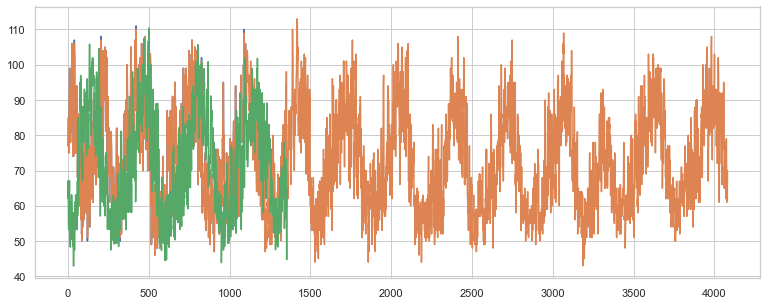

In [34]:
# I prepare the predictions on the training data to graph
# trainPredictPlot = np.empty_like(original[1:1107,4])
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict[:,4]

# I prepare the predictions on the test data to graph
# testPredictPlot = np.empty_like(dataset)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(2)+1:len(dataset)-1, :] = testPredict

# Grafico
plt.figure(figsize=(13, 5))
plt.plot(original[4:1107,4])
plt.plot(trainPredict[:,4])
plt.plot(testPredict[:,4])
plt.show()

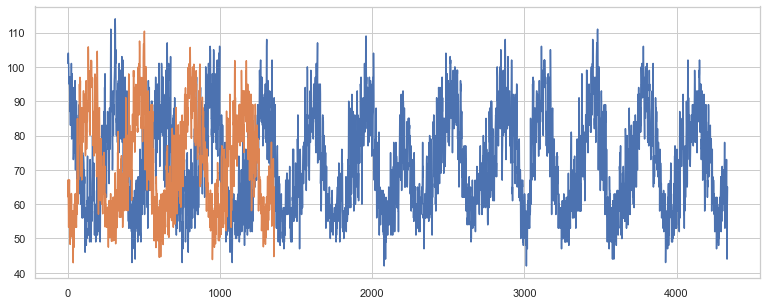

In [40]:
# Graphic
plt.figure(figsize=(13, 5))
plt.plot(original[1112:,4])
plt.plot(testPredict[:,4])
plt.show()

In [42]:
df = pd.train
df.to_csv("Imputed_Tmax.csv")

AttributeError: module 'pandas' has no attribute 'train'